In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.layers import AveragePooling2D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

c:\Users\Moussa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#creation de la fonction qui va traiter les donnees
def reg_data(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']
    
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)
    
    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month') 
    df['Day'] = df.index.get_level_values('Day') 
    df['Year'] = df.index.get_level_values('Year') 
    df.reset_index(drop=True, inplace=True)
    return df
  
#appel de la fonction reg_data


Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)





#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17], ignore_index=True)


In [5]:
Data = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')

In [6]:
Data.iloc[3:13]

,Unnamed: 0,Datum,Von,bis,MW
3,01.01.2010,00:00,00:15,0,NaN
4,01.01.2010,00:15,00:30,0,NaN
5,01.01.2010,00:30,00:45,0,NaN
6,01.01.2010,00:45,01:00,0,NaN
7,01.01.2010,01:00,01:15,0,NaN
8,01.01.2010,01:15,01:30,0,NaN
9,01.01.2010,01:30,01:45,0,NaN
10,01.01.2010,01:45,02:00,0,NaN
11,01.01.2010,02:00,02:15,0,NaN
12,01.01.2010,02:15,02:30,0,NaN


In [7]:
DataFrame.head()

,MW,Month,Day,Year
0,332.0,1,1,2010
1,1898.0,2,1,2010
2,2764.0,3,1,2010
3,12736.0,4,1,2010
4,8870.0,5,1,2010


In [8]:
#copier les donnees pour les conserver et travailler seulement avec la copie
model_data = DataFrame

In [9]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

#creer une fonction qui va faire la fraction des donnees en Data_train and DataTest
def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

2922
2191
731


In [10]:
#creation de lafonction qui va fractionner les donnees Xtrain and Ytrain puis Xtest and Ytest
def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

print(len(Xtest))
print(len(Ytest))

print(len(Xtrain))
print(len(Ytrain))

723
723
2183
2183


## GRU

In [11]:
#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(GRU(units = 8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units = 16))
model.add(Dropout(0.2))#drop out overfetting 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'mse')


model_train = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)

(723, 7, 1)
(2183, 7, 1)


Epoch 1/50
219/219 [==============================] - 13s 21ms/step - loss: 0.0502 - val_loss: 0.0771
Epoch 2/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0283 - val_loss: 0.0497
Epoch 3/50
219/219 [==============================] - 3s 14ms/step - loss: 0.0209 - val_loss: 0.0358
Epoch 4/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0177 - val_loss: 0.0320
Epoch 5/50
219/219 [==============================] - 3s 16ms/step - loss: 0.0158 - val_loss: 0.0306
Epoch 6/50
219/219 [==============================] - 4s 16ms/step - loss: 0.0158 - val_loss: 0.0309
Epoch 7/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0150 - val_loss: 0.0307
Epoch 8/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0152 - val_loss: 0.0322
Epoch 9/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0151 - val_loss: 0.0287
Epoch 10/50
219/219 [==============================] - 4s 17ms/step - loss: 0.0146 - val_l

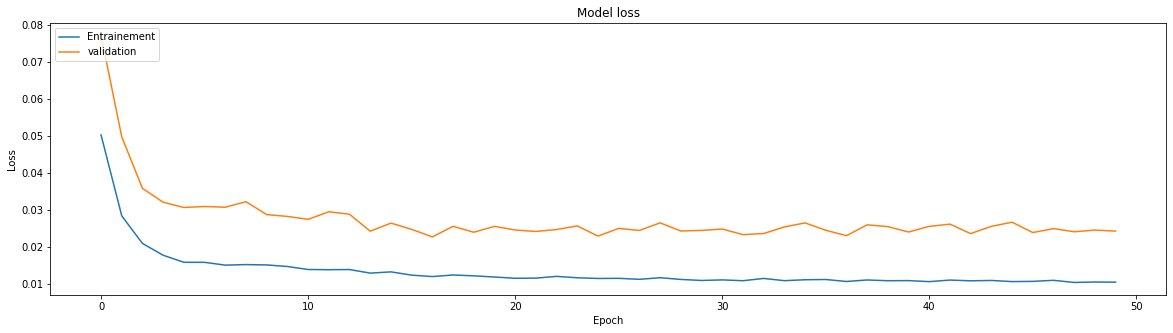

In [12]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()
    
    
ploter_Erreur(model_train)

In [13]:
# Evaluate the model on the test set
mse = model.evaluate(Xtest, Ytest, verbose=0)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 0.036324381828308105


## LSTM

In [14]:
#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(LSTM(units = 8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 16))
model.add(Dropout(0.2))#drop out overfetting 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'mse')


model_train = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)

(723, 7, 1)
(2183, 7, 1)
Epoch 1/50
219/219 [==============================] - 14s 24ms/step - loss: 0.0489 - val_loss: 0.0703
Epoch 2/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0322 - val_loss: 0.0646
Epoch 3/50
219/219 [==============================] - 4s 17ms/step - loss: 0.0291 - val_loss: 0.0607
Epoch 4/50
219/219 [==============================] - 5s 24ms/step - loss: 0.0242 - val_loss: 0.0488
Epoch 5/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0207 - val_loss: 0.0525
Epoch 6/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0187 - val_loss: 0.0383
Epoch 7/50
219/219 [==============================] - 5s 22ms/step - loss: 0.0174 - val_loss: 0.0360
Epoch 8/50
219/219 [==============================] - 4s 20ms/step - loss: 0.0162 - val_loss: 0.0337
Epoch 9/50
219/219 [==============================] - 4s 19ms/step - loss: 0.0154 - val_loss: 0.0249
Epoch 10/50
219/219 [==============================] - 4s 18ms/st

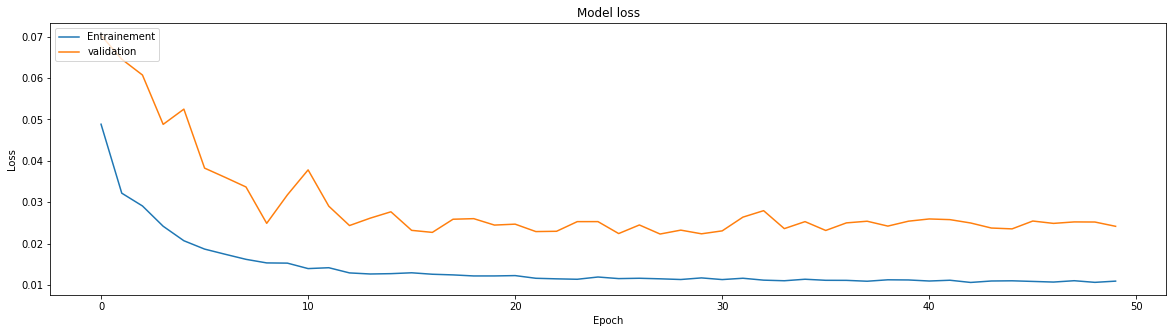

In [15]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()
    
    
ploter_Erreur(model_train)

In [16]:
# Evaluate the model on the test set
mse = model.evaluate(Xtest, Ytest, verbose=0)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 0.039354197680950165


## Transformers

In [17]:

import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow_addons as tfa
from keras.layers import MultiHeadAttention

# Define the Transformer layer
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=1)  # key_dim should be None or match input dimension
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(16),
            tf.keras.layers.Dense(8)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Define the input shape
input_shape = (7, 1)

# Define the Transformer model with Encoders and Decoders
inputs = Input(shape=input_shape)
transformer_block = TransformerLayer(num_heads=3, ff_dim=32, dropout_rate=0.2)
x = transformer_block(inputs)
x = Dense(1)(x)  # Adjust output dimension as needed

# Create the model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4), loss='mean_squared_error')

# Define your training data Xtrain and Ytrain here

# Train the model
model_train_Transformers = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)


Epoch 1/50
219/219 [==============================] - 10s 17ms/step - loss: 0.2160 - val_loss: 0.0986
Epoch 2/50
219/219 [==============================] - 2s 9ms/step - loss: 0.0548 - val_loss: 0.0611
Epoch 3/50
219/219 [==============================] - 5s 24ms/step - loss: 0.0475 - val_loss: 0.1037
Epoch 4/50
219/219 [==============================] - 5s 23ms/step - loss: 0.0436 - val_loss: 0.0657
Epoch 5/50
219/219 [==============================] - 9s 40ms/step - loss: 0.0384 - val_loss: 0.0797
Epoch 6/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0383 - val_loss: 0.0716
Epoch 7/50
219/219 [==============================] - 4s 18ms/step - loss: 0.0374 - val_loss: 0.0792
Epoch 8/50
219/219 [==============================] - 5s 21ms/step - loss: 0.0370 - val_loss: 0.0755
Epoch 9/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0359 - val_loss: 0.0958
Epoch 10/50
219/219 [==============================] - 3s 13ms/step - loss: 0.0349 - val_lo

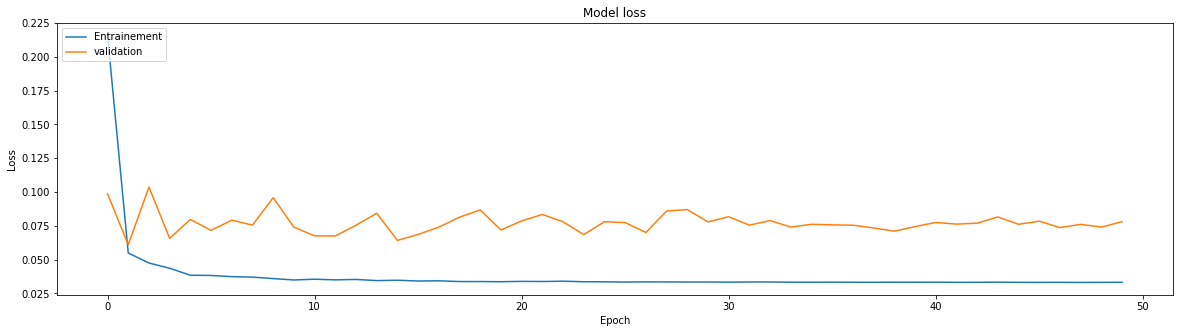

In [18]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()
    
    
ploter_Erreur(model_train_Transformers)

In [19]:
# Evaluate the model on the test set
mse = model.evaluate(Xtest, Ytest, verbose=0)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 0.10852666944265366
